In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rsna-breast-cancer-detection-data-wrangling/cleaned_data.csv
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/__results__.html
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/__notebook__.ipynb
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/cleaned_images.pickle
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/__output__.json
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/custom.css
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/__results___files/__results___22_0.png
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/__results___files/__results___24_0.png
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/__results___files/__results___23_1.png
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/__results___files/__results___21_1.png
/kaggle/input/rsna-breast-cancer-detection-data-wrangling/__results___files/__results___6_0.png


In [2]:
#Loading the pickle file containing a dictionary with 
#patient ID and image ID for keys and the cleaned images for values.
folder_path = '/kaggle/input/rsna-breast-cancer-detection-data-wrangling/'

with open(folder_path + 'cleaned_images.pickle', 'rb') as file:
    img_dict = pickle.load(file)
    
#Loading the cleaned csv file.
df = pd.read_csv(folder_path + 'cleaned_data.csv')

In [3]:
#In the first part of this notebook, we'll do EDA on the tabular data, and disregard the images. 
#Therefore, it's inconvenient to work with the dataframe df directly, because each row in df 
#corresponds to a mammogram, so in general a given patient corresponds to several rows in 
#df.

#We'll create another dataframe where the patient_id is the primary key. To do
#so, we first throw away the columns in df containing information about images, then group by
#the patient_id. In each group, each column now contains a unique value (because for example, 
#whether a given patient has cancer, or has breast implant is independent of which mammogram
#we are talking about). Finally, we aggregate with the mean function, which computes the mean
#of a list of identical values, so simply returns that single value in the list.

relevant_columns = ['age','cancer_1','biopsy_1','invasive_1',
                'BIRADS_0.0', 'BIRADS_1.0', 'BIRADS_2.0',
               'implant_1', 'density_A', 'density_B', 'density_C',
               'density_D', 'difficult_negative_case_True']

df_noimage = df[['patient_id'] + relevant_columns].groupby('patient_id').mean()

df_noimage.head()

,age,cancer_1,biopsy_1,invasive_1,BIRADS_0.0,BIRADS_1.0,BIRADS_2.0,implant_1,density_A,density_B,density_C,density_D,difficult_negative_case_True
patient_id,,,,,,,,,,,,,
25,62.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28,40.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
33,43.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
49,53.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
65,55.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
#As a consistency check, print the unique values in each column of df_noimage, and check
#that - except for the 'age' column - all the other columns only take values 0 or 1.

for col in df_noimage:
    print(df_noimage[col].unique())

[62. 40. 43. 53. 55. 59. 48. 49. 47. 57. 63. 68. 60. 44. 39. 75. 54. 66.
 45. 52. 56. 51. 71. 65. 38. 64. 50. 61. 58. 41. 69. 67. 72. 82. 42. 76.
 73. 46. 81. 83. 78. 77. 70. 74. 26. 80. 79. 84. 89. 85. 86. 87. 88. 36.
 37. 33. 35. 28. 32. 34. 30. 31. 29.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]
[1. 0.]
[0. 1.]
[0. 1.]
[0. 1.]


In [5]:
#Computing the fraction of patients with cancer.
print("fraction of patients with cancer: ",
      len(df_noimage[df_noimage['cancer_1']==1])/len(df_noimage))

fraction of patients with cancer:  0.043440786071367005


# Correlation between variables

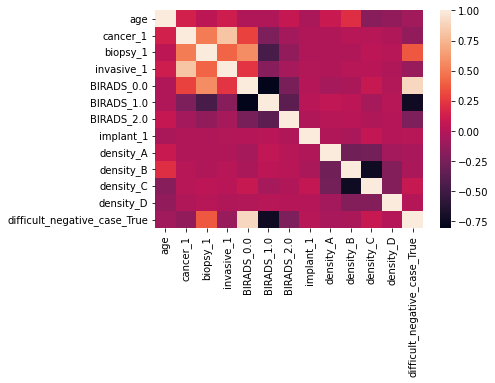

In [6]:
#Producing a heat map of the Pearson's correlation coefficients
#between the most relevant columns.
sns.heatmap(df_noimage[relevant_columns].corr());

# Exploring numerical data

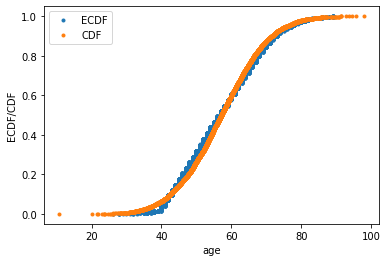

In [7]:
#First, we focus on the numerical data. There's only one column with
#numerical data: 'age'. We plot the empirical cumulative distribution 
#function (ECDF) of'age', and compare it with the plot of the CDF of the
#normal distribution with the same mean and standard deviation.

x = np.sort(df_noimage['age'])
y = np.arange(1,len(x)+1)/len(x)
_ = plt.plot(x,y, marker='.', linestyle='none')

age_mean = df_noimage['age'].mean()
age_std = df_noimage['age'].std()

samples = np.random.normal(age_mean, age_std, size=len(df_noimage['age']))
x_samples = np.sort(samples)
_ = plt.plot(x_samples,y, marker='.',linestyle='none')

_ = plt.xlabel('age')
_ = plt.ylabel('ECDF/CDF')
_ = plt.legend(['ECDF','CDF'])
plt.show()

#We see some deviations of the ECDF from the CDF of the normal distribution.

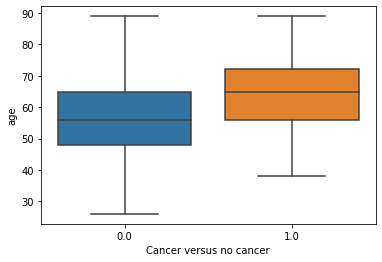

In [8]:
#Next, we make a boxplot of the age distribution, separated by whether
#the patient has cancer or not.
_ = sns.boxplot(x='cancer_1', y ='age', data=df_noimage)
_ = plt.xlabel('Cancer versus no cancer')
_ = plt.ylabel('age')
plt.show()

#We see that the median age of patients with cancer is higher than the 
#median age of patients without cancer.

In [9]:
#We can do a hypothesis testing to see if the difference of the medians
#seen above is statistically significant. First, we create two subsets 
#of the 'age' column (with cancer and without cancer)
no_cancer = df_noimage.loc[df_noimage['cancer_1']==0,'age']
has_cancer = df_noimage.loc[df_noimage['cancer_1']==1,'age']

#Next, we test if the two subsets above are normally distributed.
print(stats.normaltest(no_cancer), stats.normaltest(has_cancer))

#The small p-values mean that the data are not normally distributed !

NormaltestResult(statistic=235.7300360970258, pvalue=6.484448600061084e-52) NormaltestResult(statistic=9.256855293263223, pvalue=0.009770109095319396)


In [10]:
#Now we do the permutation test, with 10000 permutation replicates.
difference = np.empty(10000)

for i in range(10000):
    permuted_ages = np.random.permutation(df_noimage['age'])
    permuted_ages_no_cancer = permuted_ages[:len(no_cancer)]
    permuted_ages_has_cancer = permuted_ages[len(no_cancer):]
    diff = np.median(permuted_ages_no_cancer) - np.median(permuted_ages_has_cancer)
    difference[i] = diff

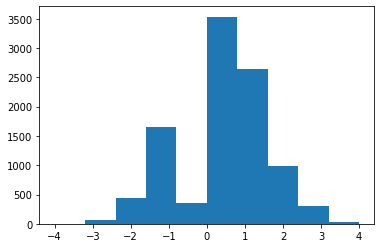

In [11]:
#We make a histogram of the differences of the median
histo = plt.hist(difference,bins=10)

In [12]:
#Computing the observed difference of the medians, and its p-value.
diff_observed = np.median(no_cancer) - np.median(has_cancer)
print("The observed difference of the medians is: ", diff_observed)

p = np.sum(difference <= diff_observed)/len(difference)
print("The p-value is: ", p)

#Because we found a p-value of zero, the observed difference between the two medians is
#statistically significant.

The observed difference of the medians is:  -9.0
The p-value is:  0.0


# Exploring categorical data

In [13]:
#Let's focus on the 'implant_1' column. We compute the fraction of patients
#with breast implant who have cancer, versus the fraction of patients without
#breast implant who have cancer. Note that we use the mean below because the column only contains
#the values 0 or 1, so the mean is equal to the fraction.
df_noimage[['cancer_1','implant_1']].groupby('implant_1').mean()

#Interestingly, the fraction is lower among patients with breast implant
# (0.017) than without (0.044). This is in agreement with some studies in the literature,
# for example:
#https://www.komen.org/breast-cancer/facts-statistics/research-studies/topics/breast-implants-and-breast-cancer-risk/#:~:text=A%20few%20studies%20in%20the,the%20implants%20themselves%20%5B2%5D.
#However, as pointed out in the website above, there are probably some confounding factors here,
#and the breast implant itself doesn't protect against cancer!

,cancer_1
implant_1,
0.0,0.044212
1.0,0.017751


In [14]:
#We repeat the above step, but with 'implant_1' replaced by other categorical features. 
df_noimage[['cancer_1','biopsy_1']].groupby('biopsy_1').mean()
#It makes sense that among the patients who did not need biopsy, none developed cancer.

,cancer_1
biopsy_1,
0.0,0.000000
1.0,0.283784


In [15]:
df_noimage[['cancer_1','invasive_1']].groupby('invasive_1').mean()
#It makes sense that all the patients with invasive tumor indeed had cancer.

,cancer_1
invasive_1,
0.0,0.014562
1.0,1.000000


In [16]:
print(df_noimage[['cancer_1','BIRADS_0.0']].groupby('BIRADS_0.0').mean())
print(df_noimage[['cancer_1','BIRADS_1.0']].groupby('BIRADS_1.0').mean())
print(df_noimage[['cancer_1','BIRADS_2.0']].groupby('BIRADS_2.0').mean())

#It makes sense that none of the patients with BI-RADS of 1 has cancer.
#See Wikipedia https://en.wikipedia.org/wiki/BI-RADS for an explanation of BI-RADS.

            cancer_1
BIRADS_0.0          
0.0         0.000000
1.0         0.122509
            cancer_1
BIRADS_1.0          
0.0         0.094844
1.0         0.000000
            cancer_1
BIRADS_2.0          
0.0         0.048452
1.0         0.000000


In [17]:
print(df_noimage[['cancer_1','density_A']].groupby('density_A').mean())
print(df_noimage[['cancer_1','density_B']].groupby('density_B').mean())
print(df_noimage[['cancer_1','density_C']].groupby('density_C').mean())
print(df_noimage[['cancer_1','density_D']].groupby('density_D').mean())
#The fraction of patients with breast_density B or C who developed cancer is higher than 
#the fraction with density A or D.

           cancer_1
density_A          
0.0        0.044588
1.0        0.032550
           cancer_1
density_B          
0.0        0.041616
1.0        0.045835
           cancer_1
density_C          
0.0        0.042149
1.0        0.045230
           cancer_1
density_D          
0.0        0.044230
1.0        0.029316


In [18]:
#Let's also compute the fraction of patients with each kind of breast density.
print("fraction of patients with breast density A: ",
      len(df_noimage[df_noimage['density_A']==1])/len(df_noimage))
print("fraction of patients with breast density B: ",
      len(df_noimage[df_noimage['density_B']==1])/len(df_noimage))
print("fraction of patients with breast density C: ",
      len(df_noimage[df_noimage['density_C']==1])/len(df_noimage))
print("fraction of patients with breast density D: ",
      len(df_noimage[df_noimage['density_D']==1])/len(df_noimage))

#We find that around 10% of patients have density A, around 43% have density B, around
#42 % have density C, and around 5% have density D. The fractions we found are close to the 
#distribution of breast density among the general population; see this website:
#https://www.cdc.gov/cancer/breast/basic_info/dense-breasts.htm#:~:text=What%20Is%20Breast%20Density%3F,as%20seen%20on%20a%20mammogram.&text=The%20breasts%20are%20almost%20entirely,about%2010%25%20of%20women).
#for more information.

fraction of patients with breast density A:  0.09532839165661093
fraction of patients with breast density B:  0.43251163592484054
fraction of patients with breast density C:  0.41923806240303396
fraction of patients with breast density D:  0.052921910015514564


# Exploring the images

In [19]:
#Let's compute the fraction of mammograms with each kind of laterality (left or right).
print("fraction of mammograms with laterality L: ",
      len(df[df['laterality_L']==1])/len(df))
print("fraction of mammograms with laterality R: ",
      len(df[df['laterality_R']==1])/len(df))
#We see that the two lateralities are roughly equally represented in the dataset.

fraction of mammograms with laterality L:  0.4976305322839976
fraction of mammograms with laterality R:  0.5023694677160023


In [20]:
#Let's compute the fraction of mammograms with each kind of view (cranio-caudal or mediolateral-oblique).
print("fraction of mammograms with view CC: ",
      len(df[df['view_CC']==1])/len(df))
print("fraction of mammograms with view MLO: ",
      len(df[df['view_MLO']==1])/len(df))
#We see that the two views are roughly equally represented in the dataset.

fraction of mammograms with view CC:  0.4862909367859863
fraction of mammograms with view MLO:  0.5137090632140137
